# Grad-CAM
La visualizacion de nombre "Grad-CAM" o Gradient weighted class activation mapping es un metodo que permite dar un "vistazo" al proceso interno de una red neuronal, ya que genera una imagen de pseudocolor partiendo de la activacion de la penultima capa de una red neuronal de clasificacon, lo cual permite determinar cual es la region a la que la red le esta dando mayor importancia al hacer la clasificación final.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.transform import resize
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
!nvidia-smi

Tue Jul  6 16:53:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Condicional para utilizar el gpu cuando esta disponible.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
local_image=False
if local_image:
    filenames=['african_elephant.png', 'autonomous_mex.png', 'beisbol.png', 'horses.png','rojas_at_angel.png', 'metro.png', 'rx_quico.png']
    filename=filenames[0]
else:
    from PIL import Image
    from urllib.request import urlopen
    url = 'https://i.pinimg.com/originals/2f/cf/d8/2fcfd89250f0774daae19e65346b2706.jpg'
    url = 'https://s3fs.bestfriends.org/s3fs-public/Introduce-cat-dog-Cappuccino-6654sak.jpg'
    filename = urlopen(url)

print(filename)

In [5]:
nombres_modelos = ['xception', 'vgg16', 'efficientnet']
seleccion       = nombres_modelos[1]

In [6]:
if seleccion == nombres_modelos[0]:
    from tensorflow.keras.applications import Xception

    scale    =  255
    img_size = (299,299,3)

    model = Xception(input_shape = img_size,
                     include_top = True,
                     weights     = 'imagenet')

    preprocess_input   = keras.applications.xception.preprocess_input
    decode_predictions = keras.applications.xception.decode_predictions

    last_conv_layer_name   = "block14_sepconv2_act"
    classifier_layer_names = ["avg_pool", "predictions",]

    model.summary()

#===============================================================================

if seleccion == nombres_modelos[1]:

    from tensorflow.keras.applications import VGG16

    scale=1
    img_size  = (224,224,3)

    model = VGG16(input_shape = img_size,
                  include_top = True,
                  weights     = 'imagenet')

    preprocess_input   = keras.applications.vgg16.preprocess_input
    decode_predictions = keras.applications.vgg16.decode_predictions

    last_conv_layer_name   = 'block5_conv3'
    classifier_layer_names =  ['block5_pool', 'flatten', 'fc1', 'fc2',"predictions",]

    model.summary()

#===============================================================================

if seleccion == nombres_modelos[2]:

    import tensorflow.keras as keras
    import efficientnet.tfkeras as efn 
    scale=255
    img_size = (224,224)
    model = efn.EfficientNetB0(weights='imagenet') 

    last_conv_layer_name   = 'top_activation'
    classifier_layer_names =  ['avg_pool', 'top_dropout', 'probs']

    model.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [7]:
def get_img_array(img_path, img_size):
    
    img = Image.open(img_path)
    
    img = img.resize(size=img_size)
    print(f'format: {img.format}, shape: {img.size}, mode: {img.mode}')
    img_array = np.array(img).astype('float32')[:,:,:3]  # tiramos el canal alpha
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

format: None, shape: (224, 224), mode: RGB


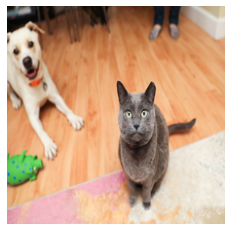

In [8]:
# load and show an image with Pillow
#'african_elephant.png',
img,img_array =  get_img_array(img_path = filename, img_size = img_size[:2])
img_array = img_array/scale
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
def Layers_List(initial_layer,model ):
    temp = False
    lista = []
    for layer in model.layers:
        if temp:
            lista.append(layer.name)
        if not temp and layer.name == initial_layer:
            temp = True
    return lista

temp = Layers_List('block4_conv1',model )
print(temp)

['block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']


In [10]:
# Imprimir las predicciones mas altas, seleccionaremos la más alta
K = 10
preds = model.predict(img_array)
decoded_predictions=decode_predictions(preds, top=10)[0]

print("{:10} {:20} {:10}".format('Id. clase', 'Nombre', 'Probabilidad'))
print(22*' -')
for decoded in decoded_predictions:
    print("{:10s} {:25s} {:0.5}".format(decoded[0], decoded[1], decoded[2]))

40960/35363 [==================================] - 0s 0us/step
Id. clase  Nombre               Probabilidad
 - - - - - - - - - - - - - - - - - - - - - -
n02124075  Egyptian_cat              0.45412
n04209239  shower_curtain            0.055721
n02110185  Siberian_husky            0.046105
n02109961  Eskimo_dog                0.041386
n02091467  Norwegian_elkhound        0.036881
n03887697  paper_towel               0.022851
n03131574  crib                      0.017645
n02808440  bathtub                   0.015863
n04493381  tub                       0.014917
n02123045  tabby                     0.014672


In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names,num_class):
    # Modelo que mapea la imagen de entrada a la capa convolucional última,
    # donde se calculará la activación
    last_conv_layer  = model.get_layer(last_conv_layer_name)
    conv_model       = keras.Model(model.inputs, last_conv_layer.output)

    # Modelo que mapea las activaciones a la salida final
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Cálculo del gradiente la salida  del modelo clasificador respecto a     
    with tf.GradientTape() as tape:
        
        # Calcula activacion del modelo base convolucional
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Calcula la predicción con modelo clasificador, para la clase mas probable
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argsort(preds[0],direction = 'DESCENDING')[num_class]
        #top_pred_index = tf.argmax(preds[0])
        print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]

    # Obtenemos el gradiente en la capa final clasificadora con respecto a
    # la salida del modelo base convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vector de pesos: medias del gradiente por capas,
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # salida de la última capa convolucional
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    # saliencia es la respuesta promedio de la última capa convolucional
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    # Multiplicación de cada canal por el vector de pesos
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Heatmap: promedio de cada canal por su peso
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
    
    return grad_cam, saliency

In [12]:
# Generate class activation heatmap
last_conv_layer_name1 = "block5_conv3"; classifier_layer_names1 =  Layers_List(last_conv_layer_name1,model)
last_conv_layer_name2 = "block5_conv2"; classifier_layer_names2 =  Layers_List(last_conv_layer_name2,model)
last_conv_layer_name3 = "block5_conv1"; classifier_layer_names3 =  Layers_List(last_conv_layer_name3,model)


grad_cam1, saliency1 = make_gradcam_heatmap(img_array, model, last_conv_layer_name1, classifier_layer_names1,2)
grad_cam2, saliency2 = make_gradcam_heatmap(img_array, model, last_conv_layer_name2, classifier_layer_names2,2)
grad_cam3, saliency3 = make_gradcam_heatmap(img_array, model, last_conv_layer_name3, classifier_layer_names3,2)


tf.Tensor(250, shape=(), dtype=int32)
tf.Tensor(250, shape=(), dtype=int32)
tf.Tensor(250, shape=(), dtype=int32)


Sumamos los grad cams

In [13]:
grad_cam = grad_cam1 + grad_cam2 + grad_cam3 

In [14]:
def show_hotmap (img, heatmap, title='Heatmap', alpha=0.6, cmap='jet', axisOnOff='off'):
    '''
    img     :    Image
    heatmap :    2d narray
    '''
    resized_heatmap=resize(heatmap, img.size)
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(resized_heatmap, alpha=alpha, cmap=cmap)
    plt.axis(axisOnOff)
    plt.title(title)
    plt.show()

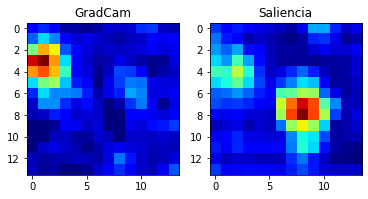

In [15]:
plt.subplot(121)
plt.imshow(grad_cam, 'jet')
plt.title('GradCam')
plt.subplot(122)
plt.imshow(saliency1, 'jet')
plt.title('Saliencia')
plt.show()

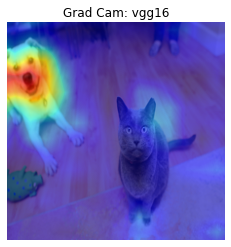

In [16]:
show_hotmap(img=img, heatmap=grad_cam, title=f'Grad Cam: {model.name}')

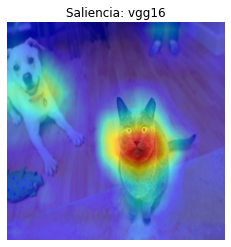

In [17]:
show_hotmap(img=img, heatmap=saliency1, title=f'Saliencia: {model.name}')